# Zero-dimensional model of sediment accumulation on Polder 32 in Southwest Bangladesh

## Prepare notebook

Import all packages

In [1]:
import pandas as pd
import numpy as np
import os
import sys
from pathlib import Path
import subprocess
import feather
from tqdm.notebook import tqdm
import itertools as it
import inspect
import shutil
import re
from collections import namedtuple
from pyprojroot import here
from joblib import Parallel, delayed
import scipy
import ipympl
from matplotlib import pyplot as plt

Set project root

In [2]:
root = here()

Set parameters for the model run.

In [3]:
cpu_num = 1

# Set model parameters
run_len = 1  # years
dt = "1 sec"  # timestep must be given as a timedelta string
slr = 0.003  # yearly rate (m) (0.002 ESLR + 0.001 Tidal Amp)

if cpu_num != 1:
    slr = np.round(np.arange(0, 0.0325, 0.0025), 4)
    ssc_factor = np.round(np.arange(0.25, 3.25, 0.25), 2)

## Make tides

Define functions that will be used to search for any missing tides and then create them.

In [4]:
def make_combos(**kwargs):
    '''
    Function that takes n-kwargs and returns a list of namedtuples
    for each possible combination of kwargs.
    '''
    for key, value in kwargs.items():
        if isinstance(value, (list, tuple, np.ndarray)) is False:
            kwargs.update({key: [value]})
    keys, value_tuples = zip(*kwargs.items())
    combo_tuple = namedtuple("combos", keys)
    combos = [combo_tuple(*values) for values in it.product(*value_tuples)]
    return combos


def construct_filename(fn_format, **kwargs):
    '''
    Function that takes a string with n-number of format placeholders (e.g. {0]})
    and uses the values from n-kwargs to populate the string.
    '''
    kwarg_num = len(kwargs)
    fn_var_num = len(re.findall(r"\{.*?\}", fn_format))
    if kwarg_num != fn_var_num:
        raise Exception(
            "Format error: Given {0} kwargs, but "
            "filename format has {1} sets of "
            "braces.".format(kwarg_num, fn_var_num)
        )
    fn = fn_format.format(*kwargs.values())
    return fn


def search_file(wdir, filename):
    '''
    Function that searches a directory for a filename and returns 0 the number
    of exact matches (0 or 1). If more than one file is found, the function
    will raise an exception.
    '''
    if len(list(Path(wdir).glob(filename))) == 0:
        found = 0
    elif len(list(Path(wdir).glob(filename))) == 1:
        found = 1
    elif len(list(Path(wdir).glob(filename))) > 1:
        raise Exception("Found too many files that match.")
    return found


def missing_combos(wdir, fn_format, combos):
    '''
    Function that creates filenames for a list of combinations and 
    then searches a directory for the filenames. The function returns
    a list of combinations that were not found.
    '''
    to_make = []
    for combo in combos:
        fn = construct_filename(
            fn_format=fn_format,
            run_len=combo.run_len,
            dt=int(pd.to_timedelta(combo.dt).total_seconds()),
            slr=combo.slr,
        )
        if search_file(wdir, fn) == 0:
            to_make.append(combo)
    return to_make


def make_tide(params):
    '''
    Function that accepts a namedtuple or dictionary object containing
    the arguments: wdir, fn_format, run_length, dt, and slr. These values
    are passed to the Rscript make_tides.R which creates a discretized tidal
    curve with timesteps of dt and a total length of run_len. Sea level rise
    is added to the curve using a yearly rate of SLR. The tidal data is stored in
    wdir as a feather file for interopability between R and Python.
    '''
    fn = construct_filename(
        fn_format=params.fn_format,
        run_len=params.run_len,
        dt=int(pd.to_timedelta(params.dt).total_seconds()),
        slr=params.slr,
    )
    if params.wdir.is_dir() is False:
        params.wdir.mkdir()

    R_command = "Rscript"
    script_path = (root / "scripts" / "make_tides.R").absolute().as_posix()
    args = [
        str(params.run_len),
        str(params.dt),
        "{:.4f}".format(params.slr),
        params.wdir.absolute().as_posix(),
    ]
    cmd = [R_command, script_path] + args
    subprocess.check_output(cmd, universal_newlines=True)
    msg = "Tide created: {0}".format(fn)
    return msg


def load_tide(wdir, filename):
    '''
    Function that loads the tidal curve constructed by make_tides.R
    and sets the index to the Datetime column.
    '''
    fp = wdir / filename
    tides = feather.read_dataframe(fp)
    tides = tides.set_index("Datetime")

    return tides


def continuous_to_discrete_tides(fx, x=None, periods=None):
    if x is None and period is None:
        raise Exception("x or periods must be specified.")
    elif x is not None and periods is not none:
        raise Exception("Only x or periods can be specified; not both.")
    elif isinstance(x, (list, tuple, np.ndarray, pd.RangeIndex, pd.DatetimeIndex)) is False:
        raise Exception("x must be a list, tuple, numpy array, or pandas range index.")
    elif isinstance(periods, (int, float)) is False:
        raise Exception('periods must be an int or a float.')
    fun = lambda x: eval(fx)
    data = [fun(i) for i in np.arange(len(x))]
    df = pd.DataFrame(data = data, columns = ['pressure'], index=x)
    return df

Make all missing tides.

In [5]:
dir = root / "data" / "interim" / "tides"
fn_format = "tides-yr_{0}-dt_{1}-slr_{2:.4f}.feather"
tide_combos = make_combos(slr=slr, run_len=run_len, dt=dt)
missing = missing_combos(dir, fn_format, tide_combos)
params_for_make_tide = namedtuple(
    "params_for_make_tide", ("wdir", "fn_format") + tide_combos[0]._fields
)
tides_to_make = [
    params_for_make_tide(
        wdir=dir, fn_format=fn_format, slr=item.slr, run_len=item.run_len, dt=item.dt
    )
    for item in missing
]

if len(tides_to_make) > 0:
    Parallel(n_jobs=cpu_num)(delayed(make_tide)(i) for i in tides_to_make)
else:
    print('All tides already in library.')

## Run the sediment model

Define functions that will be used to run the sediment model

In [6]:
def return_bound_conc(bound_conc, method, timestamp=None):
    if method == "constant":
        return bound_conc
    elif method == "weekly":
        week = timestamp.week
        bound_conc = sed_conc.loc[week].values[0]
        return bound_conc


def calc_conc(
    bound_conc, tide_height, tide_height_min_1, conc_min_1, elev, elev_min_1, settle_rate, timestep
):
    depth = tide_height - elev
    depth_min_1 = tide_height_min_1 - elev_min_1
    change_in_depth = depth - depth_min_1

    # Checks
    tide_above_platform = np.bool(tide_height > elev)
    prev_tide_above_platform = np.bool(tide_height_min_1 > elev)
    tide_increasing = np.bool(tide_height > tide_height_min_1)
    settling_valid = np.bool(settle_rate * conc_min_1 * timestep <= depth_min_1 * conc_min_1)
    checks = [tide_above_platform, tide_increasing, settling_valid]

    term1 = conc_min_1
    term2 = (settle_rate * conc_min_1) / depth_min_1 * timestep
    term3 = 1
    term4 = bound_conc * change_in_depth
    term5 = conc_min_1 * change_in_depth

    if tide_increasing is False:
        term3 = 0
    if settling_valid is False:
        term1 = term2 = 0
    if tide_above_platform is True:
        conc = term1 - term2 + term3 * (term4 - term5)
    elif tide_above_platform is False:
        conc = 0

    terms = [term1, term2, term3, term4, term5]

    return conc, terms, checks


def accumulate_sediment(conc, settle_rate, timestep):
    deposited_sediment = settle_rate * conc * timestep
    return deposited_sediment


def aggrade(start_elev, sediment, organic, compaction, subsidence):
    elev = start_elev + sediment + organic - compaction - subsidence
    return elev


def return_settle_rate(grain_den, grain_dia):
    fluid_den = 1000
    fluid_visc = 0.001
    g = 9.8
    settle_rate = (
        (2 / 9 * (grain_den - fluid_den) / fluid_visc) * g * (grain_dia / 2) ** 2
    )
    return settle_rate

Run the model. Work in progress. Normally, these parameters will be defined at the top of the document.

In [16]:
bound_conc = 0.8 # g/L
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650  # density of quartz kg/m3
bulk_den = 1300 # kg/m3
compaction_rate = 0
organic_rate = 0
subsidence_rate = 0
start_elev = 1.25


tides = load_tide(dir, "tides-yr_1-dt_1-slr_0.0030.feather")
#tides = load_tide(dir, "tides-debug.feather")*2
index = tides.index
timestep = index[1] - index[0]
timestep_sec = timestep.total_seconds()

organic = organic_rate / 8760 / 60 / 60 * timestep_sec
compaction = compaction_rate / 8760 / 60 / 60 * timestep_sec
subsidence = subsidence_rate / 8760 / 60 / 60 * timestep_sec
settle_rate = return_settle_rate(grain_den, grain_dia)

elev = np.zeros(len(tides.index))
elev[0] = start_elev
elev_change = np.zeros(len(tides.index))
tide_height = tides.pressure.values
bound_conc = np.full(len(tides.index), bound_conc)
conc = np.zeros(len(tides.index))
deposited_sediment = np.zeros(len(tides.index))
depth = np.full(len(tides.index), np.nan)

#debug terms
term1 = np.full(len(tides.index), np.nan)
term2 = np.full(len(tides.index), np.nan)
term3 = np.full(len(tides.index), np.nan)
term4 = np.full(len(tides.index), np.nan)
term5 = np.full(len(tides.index), np.nan)

counter = np.arange(1, len(index))

for t in tqdm(
    counter,
    total=len(index[1:]),
    unit="steps",
):
    elev[t] = aggrade(elev[t - 1], elev_change[t - 1], organic, compaction, subsidence)
    depth[t] = tide_height[t] - elev[t]
    conc[t], terms, checks = calc_conc(
        bound_conc[t],
        tide_height[t],
        tide_height[t - 1],
        conc[t - 1],
        elev[t],
        elev[t-1],
        settle_rate,
        timestep_sec
    )
    term1[t] = terms[0]
    term2[t] = terms[1]
    term3[t] = terms[2]
    term4[t] = terms[3]
    term5[t] = terms[4]
    deposited_sediment[t] = accumulate_sediment(
        conc[t], settle_rate, timestep_sec
    )
    elev_change[t] = deposited_sediment[t] / bulk_den

data = pd.DataFrame(data={'elev': elev, 'tide': tide_height,
                          'depth': depth, 'bound_conc': bound_conc, 'conc': conc, 'term1' :term1,
                          'term2': term2, 'term3': term3, 'term4': term4, 'term5': term5,'deposited_sediment': deposited_sediment}, index=index)
data['suspended_sediment'] = (data.conc * depth)
data['incoming_sediment'] = 0.2 * (data.depth - data.depth.shift(1))
data.incoming_sediment = np.where(data.incoming_sediment < 0, 0, data.incoming_sediment)

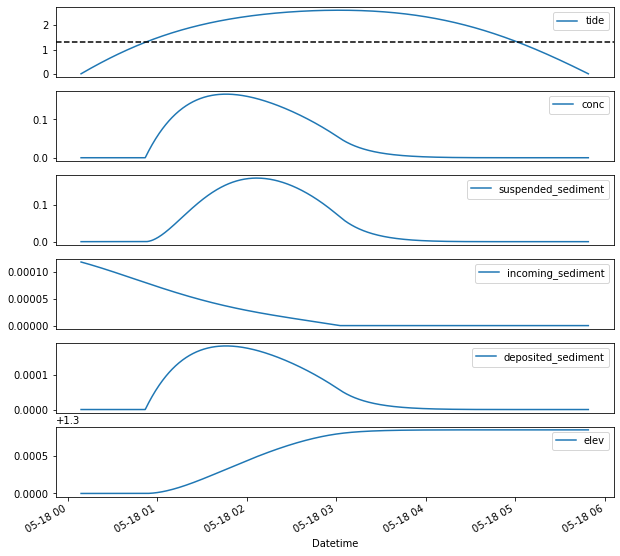

In [12]:
plot_data = data.copy()
plot_data = plot_data.sample(frac=0.1)
start = 0
end = -1

figure, axes = plt.subplots(nrows=6, ncols=1, figsize=(10,10))
p1 = plot_data[start:end][['tide']].plot(ax=axes[0]).xaxis.set_visible(False)
axes[0].axhline(start_elev,color='black',ls='--')
p2 = plot_data[start:end][['conc']].plot(ax=axes[1]).xaxis.set_visible(False)
p3 = plot_data[start:end][['suspended_sediment']].plot(ax=axes[2]).xaxis.set_visible(False)
p4 = plot_data[start:end][['incoming_sediment']].plot(ax=axes[3]).xaxis.set_visible(False)
p5 = plot_data[start:end][['deposited_sediment']].plot(ax=axes[4]).xaxis.set_visible(False)
p6 = plot_data[start:end][['elev']].plot(ax=axes[5])

pressure    1.234543
dtype: float64

## OLD MODEL [DEPRICATED]

In [6]:
# Main function for running the model.
# def run_model(tides, ssc, params, n = None)
# Instead of grain_dia, you use params.grain_dia, params.grain_rho, etc.
def run_model(
    tides, ssc, grain_dia, grain_rho, bulk_rho, dP=0, dO=0, dM=0, A=1, z0=0, n=None
):
    global num_runs

    # Function that sets the background SSC value given a method.
    def find_ssc(ssc, method, timestamp=None):
        if method == "constant":
            return ssc
        elif method == "weekly":
            week = timestamp.week
            ssc = ssc.loc[week].values[0]
            return ssc

    # Return suspended sediment values from a csv of average weekly suspended sediment for P32. When tide is below the
    # the platform (no sedimentation) or the tide is falling (net export), "0" is returned.

    # Calculate the concentration within the water column for a given timestep
    # old method
    #     def calc_c(c0, h, h_min_1, dh, c_min_1, z, ws, dt):
    #         if (h > z and dh > 0):
    #             return (-c_min_1 * ws * dt + (c0-c_min_1) * (h - h_min_1)) / (h_min_1-z) + c_min_1
    #         elif (h > z and dh < 0):
    #             return (-c_min_1 * ws * dt) / (h_min_1-z) + c_min_1
    #         else:
    #             return 0

    # Method from work with David
    def calc_c(c0, h, h_min_1, dh, c_min_1, z, ws, dt):
        if h > z and dh > 0:
            return (-c_min_1 * ws * dt + (c0 - c_min_1) * (h - h_min_1)) / (
                h_min_1 - z
            ) + c_min_1
        elif h > z and dh < 0:
            return (-c_min_1 * ws * dt) / (h_min_1 - z) + c_min_1
        else:
            return 0

    #     added by JG
    #     global g_calc_c
    #     g_calc_c = calc_c

    # Calculate the change in elevation for a given timestep
    def calc_dz(c, ws, rho, dt):
        return ws * c * dt / rho

    # Add the change of elevation back to the original elevation
    def calc_z(z_min_1, dz_min_1, dO, dP, dM):
        return z_min_1 + dz_min_1 + dO - dP - dM

    # Set method to be used for ssc based on ssc input type
    if isinstance(ssc, float):
        ssc_method = "constant"
    elif isinstance(ssc, pd.DataFrame):
        ssc_method = "weekly"

    # Set Datetime as the index. Feather does not export non-integer indices.
    tides = tides.set_index("Datetime")
    index = tides.index
    dt = index[1] - index[0]
    dt_sec = dt.total_seconds()

    # Convert constant rates from yearly to dt
    dO = dO / 8760 / 60 / 60 * dt_sec
    dP = dP / 8760 / 60 / 60 * dt_sec
    dM = dM / 8760 / 60 / 60 * dt_sec

    # Assume density and viscosity of water
    fluid_rho = 1000
    fluid_visc = 0.001
    g = 9.8

    # Calculate settling velocity using Stokes settling. Considered an upper bound for possible settling velocity.
    ws = (2 / 9 * (grain_rho - fluid_rho) / fluid_visc) * g * (grain_dia / 2) ** 2

    # Initialize numpy arrays for efficiency
    z = np.zeros(len(tides.index))
    z[0] = z0
    h = tides.pressure.values
    dh = np.insert(np.diff(h) / dt_sec, 0, np.nan)
    inundated = np.zeros(len(tides.index))
    inundation_depth = np.zeros(len(tides.index))
    C0 = np.zeros(len(tides.index))
    C = np.zeros(len(tides.index))
    dz = np.zeros(len(tides.index))
    SSC = np.zeros(len(tides.index))

    #     def update_elevation(z, SSC, C0, C, dz, h, dh, dO, dP, dM, A, ssc, bulk_rho, dt_sec, ws, ssc_method, timestamp):
    #         z[t] = calc_z(z[t-1], dz[t-1], dO, dP, dM)
    #         SSC[t] = find_ssc(ssc, method=ssc_method, timestamp=index[t])
    #         C0[t] = calc_c0(h[t], dh[t], ssc, z[t], A)
    #         C[t] = calc_c(C0[t], h[t], h[t-1], dh[t], C[t-1], z[t], ws, dt_sec)
    #         dz[t] = calc_dz(C[t], ws, bulk_rho, dt_sec)

    # For loop to calculate backwards difference approximation.
    # TQDM is a wrapper that shows a status bar while calculating.
    counter = np.arange(1, len(index))
    for t in tqdm(
        counter,
        desc="Run {0} of {1} [PID: {2}]".format(n, num_runs, os.getpid()),
        total=len(index[1:]),
        unit="steps",
    ):
        # update_elevation(z = z, SSC = SSC, C0 = C0, C = C,
        #                  dz = dz, h =  h, dh = dh, dO = dO, dP = dP, dM = dM,
        #                  A = A, ssc = ssc, bulk_rho = bulk_rho, dt_sec = dt_sec,
        #                  ws = ws, ssc_method = ssc_method, timestamp = timestamp)
        z[t] = calc_z(z[t - 1], dz[t - 1], dO, dP, dM)
        SSC[t] = find_ssc(ssc, method=ssc_method, timestamp=index[t])
        C0[t] = SSC[t] * A
        C[t] = calc_c(C0[t], h[t], h[t - 1], dh[t], C[t - 1], z[t], ws, dt_sec)
        dz[t] = calc_dz(C[t], ws, bulk_rho, dt_sec)
        # Flag if inundated and by how much
        if h[t] - z[t] >= 0:
            inundated[t] = 1
            inundation_depth[t] = h[t] - z[t]

    # Create pandas dataframe from numpy arrays of finite difference results
    d = {
        "h": h,
        "dh": dh,
        "C0": C0,
        "C": C,
        "dz": dz,
        "z": z,
        "inundated": inundated,
        "inundation_depth": inundation_depth,
    }
    df = pd.DataFrame(data=d, index=tides.index)

    return df

Create helper functions for parallel processing

In [7]:
# Function to be called by parallel function (e.g. imap_unordered). This is necessary because imap only accepts
# one function and one iterable. Using this parser allows the model to be run with multiple iterables package as
# one tuple
def parallel_parser(in_data):

    n = in_data["n"]  # number to explicitly set print line for TQDM. Not working.

    # Load tides for a given run_length, dt, and slr from the tide library.
    run_length = in_data["run_length"]
    dt = in_data["dt"]
    slr = in_data["slr"]
    tides = feather.read_dataframe(
        "./data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather".format(
            run_length, int(pd.to_timedelta(dt).total_seconds() / 60 / 60), "%.4f" % slr
        )
    )
    # Set Datetime as the index. Feather does not export non-integer indices.
    tides = tides.set_index("Datetime")

    # Load weekly ssc data. Original data from OBS sensor deployed at Sutarkhali. Data is in 1-min increments. Developed
    # a model to predict SSC by week of the year (incoming_ssc.R). Output of this script is the weekly SSC loaded here.
    ssc_factor = in_data["ssc_factor"]  # scaling factor used to adjust SSC
    ssc_file = "./data/processed/ssc_by_week.csv"
    ssc = pd.read_csv(ssc_file, index_col=0) * ssc_factor

    # set parameters for model run
    grain_dia = in_data["grain_dia"]
    grain_rho = in_data["grain_rho"]
    bulk_rho = in_data["bulk_rho"]
    dP = in_data["dP"]
    dO = in_data["dO"]
    dM = in_data["dM"]
    A = in_data["A"]
    z0 = in_data["z0"]

    # run model
    # params = in_data["params"]
    # run_model(tides = tides, ssc = ssc, params = params, n = n)
    run_model(tides, ssc, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0, n=n)

    # Write results to a feather file
    out_name = "yr_{0}-slr_{1}-grain_dia_{2}-grain_rho_{3}-bulk_rho_{4}-sscfactor_{5}-dP_{6}-dM_{7}-A_{8}-z0_{9}.feather".format(
        run_length, slr, grain_dia, grain_rho, bulk_rho, ssc_factor, dP, dM, A, z0
    )
    feather.write_dataframe(
        df.reset_index(), "./data/interim/results/{0}".format(out_name)
    )

    return

In [8]:
# Parallel method
if parallel == True:

    # Make combos of parameters
    model_runs = make_combos(
        run_length,
        dt,
        slr,
        ssc_factor,
        grain_dia,
        grain_rho,
        bulk_rho,
        dP,
        dO,
        dM,
        A,
        z0,
    )

    # Count number of models to be run
    num_runs = len(model_runs)

    # Initialize pool and run models
    with mp.Pool(poolsize) as pool:
        for result in pool.imap_unordered(
            parallel_parser, model_runs, chunksize=chunksize
        ):
            pass

# Single core method
elif parallel == False:

    # Load tides from tide library
    tides = feather.read_dataframe(
        "./data/interim/tides/tides-yr_{0}-dt_{1}-slr_{2}.feather".format(
            run_length, int(pd.to_timedelta(dt).total_seconds() / 60), "%.4f" % slr
        )
    )

    # Set number of models to be run
    num_runs = 1

    # run model
    # df = run_model(tides = tides, ssc = ssc, params = params, n = 1)
    df = run_model(tides, ssc, grain_dia, grain_rho, bulk_rho, dP, dO, dM, A, z0, n=1)

    # write results to feather file
    out_name = "yr_{0}-slr_{1}-grain_dia_{2}-grain_rho_{3}-bulk_rho_{4}-sscfactor_{5}-dP_{6}-dM_{7}-A_{8}-z0_{9}.feather".format(
        run_length, slr, grain_dia, grain_rho, bulk_rho, ssc_factor, dP, dM, A, z0
    )
    feather.write_dataframe(
        df.reset_index(), "./data/interim/results/{0}".format(out_name)
    )